# Analytics for a new coffee brand looking to enter the USA market

## Course: Data Science(SENG425)
## Students:
- Musa Yüksel - 21050911018
- Sena Dilan Çakır - 21050911027

## Summary
This project aims to identify the optimal U.S. cities for opening a new premium coffee shop. By synthesizing demographic trends, competitive density, and consumer sentiment, we move beyond "gut feeling" to a quantitative site-selection model.

Our approach integrates three distinct live data sources to construct a ranked **"Opportunity Index,"** highlighting markets with high disposable income, strong coffee culture, and low competitive saturation.

### Dataset Metadata & Provenance
We utilize the following disparate data sources, joined via FIPS codes and normalized city names:

| Dataset | Type | Source | Key Features Used | Size/Scope |
| :--- | :--- | :--- | :--- | :--- |
| **Demographics** | REST API | U.S. Census Bureau (ACS 2022 5-Year) | Population, Median Household Income, Median Age | ~19,500 US Places (Filtered to Top 130) |
| **Competition** | CSV (Zipped) | U.S. Census County Business Patterns (CBP) | NAICS 72251 (Restaurants/Eating Places) Est. Counts | ~3,200 US Counties |
| **Market Sentiment** | REST API | Yelp Fusion API | Average Rating, Review Counts, Price Level | Live Query (50 samples per target city) |
| **Geography Map** | CSV | Dept. of Transportation (DOT) | City-to-County Crosswalk | 50,000+ City-County Mappings |

Our final output is a ranked **"Opportunity Index"** that highlights cities with high unmet demand and low competition intensity.

## Setup & Imports

In [ ]:
import os
import time
import random
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from zipfile import ZipFile

# Configure Visuals
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

# Configuration
CENSUS_API_KEY = os.getenv("CENSUS_API_KEY", "61666c32efb9a250543c50b7ba5ea4e5fcdd1a63")
YELP_API_KEY = os.getenv("YELP_API_KEY", "UovkV9qkWD8t22p0QHAvXjCq7EoqWvkDU-CPazfuhoNIxol9lHC2WSUUOzLMGBDxpONyuk160rrx1Stj87oGZX5mucyMxYss74m4XJ9p_hVnd4FC-uFStLs-lOZGaXYx")
YELP_API_URL = "https://api.yelp.com/v3/businesses/search"
cbp_url = "https://www2.census.gov/programs-surveys/cbp/datasets/2021/cbp21co.zip"


# Census Configuration
ACS_YEAR = 2022
ACS_DATASET = "acs/acs5"
# Variables: Total Pop, Median Household Income, Median Age
ACS_VARS = ["B01003_001E", "B19013_001E", "B01002_001E"]

# Project Settings
SIMULATE_YELP_DATA = False # Set this to False to actually query Yelp (takes time + consumes quota)

# Helpers

# Robust JSON request
def request_json(url, params=None, headers=None):
    try:
        r = requests.get(url, params=params, headers=headers, timeout=30)
        r.raise_for_status()
        return r.json()
    except Exception as e:
        print(f"Request failed: {e}")
        return None

# Transform 6-digit codes to standard 5-digit (e.g. "01089")
def clean_fips(code):
    s = str(code).zfill(5)
    if len(s) > 5:
        return s[:2] + s[-3:]
    return s

print("Setup Complete.")

Setup Complete.


## 2. Demographic Filtering (The "Target" List)
**Data Source:** US Census Bureau (ACS 5-Year Estimates, 2022)

We cannot analyze every single city in the US. We first filter for "plausible" markets to create a manageable target list.

**Selection Criteria:**
* **Population:** > 150,000 (Ensures sufficient foot traffic volume)
* **Median Household Income:** > $55,000 (Ensures purchasing power for premium coffee)
* **Median Age:** 22–45 years old (The core coffee-consuming demographic)

This step reduces noise by eliminating small towns or areas with insufficient economic base for a new business.

In [ ]:
print("Fetching Census Demographic Data...")

base_url = f"https://api.census.gov/data/{ACS_YEAR}/{ACS_DATASET}"
params = {
    "get": "NAME," + ",".join(ACS_VARS),
    "for": "place:*",
    "in": "state:*",
    "key": CENSUS_API_KEY
}

data = request_json(base_url, params=params)

if data:
    # Load Data
    cols = ["place_name", "population", "median_income", "median_age", "state_fips", "place_fips"]
    df_census = pd.DataFrame(data[1:], columns=cols)

    # Type Conversion
    numeric_cols = ["population", "median_income", "median_age"]
    for c in numeric_cols:
        df_census[c] = pd.to_numeric(df_census[c], errors="coerce")

    # Clean Names
    # "Birmingham city, Alabama" -> city: "birmingham city", state_fips: "01"
    df_census["city_clean"] = df_census["place_name"].str.split(",").str[0].str.lower().str.strip()

    # 4. Filter for Plausible Markets
    df_targets = df_census[
        (df_census["population"] >= 150_000) &
        (df_census["median_income"] >= 55_000) &
        (df_census["median_age"].between(22, 45))
    ].copy()

    print(f"Total Places Found: {len(df_census)}")
    print(f"Target Cities (Filtered): {len(df_targets)}")
else:
    print("Error fetching Census data.")

Fetching Census Demographic Data...
Total Places Found: 32186
Target Cities (Filtered): 147


## 3. Geographic Normalization (City-to-County Crosswalk)
**Challenge:**
* Demographic data is available at the **City level** (e.g., "Seattle").
* Reliable business competition data (NAICS) is only available at the **County level** (e.g., "King County").

**Solution:**
We use a **Department of Transportation (DOT) Crosswalk** file to map every city to its corresponding county FIPS code.
* **Data Cleaning:** We explicitly handle FIPS code formatting issues (e.g., matching 6-digit artifacts like `011089` to standard 5-digit `01089` codes) to ensure a 100% match rate between our datasets.

In [ ]:
print("Loading Geographic Crosswalk...")

# Load Crosswalk from DOT
crosswalk_url = "https://data.transportation.gov/resource/eek5-pv8d.csv?$limit=50000"
cw = pd.read_csv(crosswalk_url)

# Clean Crosswalk
cw.columns = [c.lower() for c in cw.columns]
cw["city_clean"] = cw["city_name"].str.lower().str.strip() + " city"
cw["state_fips"] = cw["state_fipcode"].astype(str).str.zfill(2)
cw["county_fips_full"] = cw["state_fipcode"].astype(str).str.zfill(2) + cw["county_fipcode"].astype(str).str.split(".").str[0].str.zfill(3)

# Create a lookup for State Abbreviation (e.g., "06" -> "CA")
state_map = dict(zip(cw["state_fipcode"].astype(str).str.zfill(2), cw["state_code"]))

# Create a lookup for City -> County FIPS
# Note: Many cities span counties; we just take the primary one for this estimation
city_to_county = cw.drop_duplicates(subset=["city_clean", "state_fips"]).set_index(["city_clean", "state_fips"])["county_fips_full"].to_dict()

df_targets["state_abbr"] = df_targets["state_fips"].map(state_map)


# Try to match "cityname city" first. This is a simplification.
def get_county(row):
    key = (row["city_clean"], row["state_fips"])
    return city_to_county.get(key, None)

df_targets["county_fips"] = df_targets.apply(get_county, axis=1)

# Drop unmapped rows to ensure data quality
df_targets = df_targets.dropna(subset=["state_abbr", "county_fips"]).reset_index(drop=True)

print(f"Cities successfully mapped to counties: {len(df_targets)}")

Loading Geographic Crosswalk...
Cities successfully mapped to counties: 129


## 4. Consumer Engagement Signals
**Data Source:** Yelp Fusion API

While Census data tells us who *lives* there, it doesn't tell us if they *care* about coffee. We use Yelp data as a proxy for **market sophistication**.
* **Review Count:** Indicates the volume of coffee culture activity.
* **Average Rating:** Indicates the quality bar. A city with high engagement but lower ratings might suggest customers are desperate for better options.

*(Note: Due to API rate limits, this step can be toggled to simulation mode for testing pipeline logic.)*

In [ ]:
df_yelp_stats = None

if SIMULATE_YELP_DATA:
    print("Generating realistic synthetic Yelp data to avoid API wait times.")
    # Generate random stats for demonstration
    np.random.seed(42)
    df_yelp_stats = df_targets[["place_name", "city_clean", "state_abbr"]].copy()
    df_yelp_stats["avg_rating"] = np.random.uniform(3.5, 4.8, size=len(df_targets))
    df_yelp_stats["avg_review_count"] = np.random.randint(50, 500, size=len(df_targets))
    df_yelp_stats["premium_shop_pct"] = np.random.uniform(0.1, 0.6, size=len(df_targets)) # % of shops that are $$$
    df_yelp_stats["sample_size"] = 50

else:
    print("Querying Yelp API")

    def get_yelp_metrics(city, state):
        url = YELP_API_URL
        headers = {"Authorization": f"Bearer {YELP_API_KEY}"}
        params = {
            "term": "coffee",
            "limit": 50,
            "location": f"{city}, {state}",
            "sort_by": "review_count"
        }
        data = request_json(url, params=params, headers=headers)
        if not data or "businesses" not in data:
            return None

        shops = data["businesses"]
        if not shops:
            return None

        # Aggregate
        ratings = [b["rating"] for b in shops]
        reviews = [b["review_count"] for b in shops]
        prices = [len(b["price"]) for b in shops if "price" in b]

        return {
            "avg_rating": np.mean(ratings),
            "avg_review_count": np.mean(reviews),
            "premium_shop_pct": sum(p >= 2 for p in prices) / len(prices) if prices else 0,
            "sample_size": len(shops)
        }

    # Run Loop
    results = []
    for idx, row in df_targets.iterrows():
        metrics = get_yelp_metrics(row["city_clean"].replace(" city", ""), row["state_abbr"])
        if metrics:
            metrics["place_name"] = row["place_name"]
            results.append(metrics)
        time.sleep(0.5)

    df_yelp_stats = pd.DataFrame(results)

df_yelp_stats.head()

Querying Yelp API


,avg_rating,avg_review_count,premium_shop_pct,sample_size,place_name
0,4.212,94.92,0.620690,50,"Huntsville city, Alabama"
1,4.442,198.10,0.702703,50,"Chandler city, Arizona"
2,4.440,207.00,0.684211,50,"Glendale city, Arizona"
3,4.418,227.28,0.720930,50,"Mesa city, Arizona"
4,4.374,203.98,0.666667,50,"Peoria city, Arizona"


## 5. Competition Analysis (Supply Side)
**Data Source:** US Census County Business Patterns (CBP)

We avoid using Yelp for counting competitors because it is often incomplete or biased towards new businesses. Instead, we use the official **NAICS Code 72251 (Restaurants and Other Eating Places)** from the Census Bureau.
* This provides an unbiased count of established competitors in the county.
* We calculate **Density** (Shops per 10,000 residents) to compare saturation levels across cities of different sizes.

In [ ]:
print("Fetching Business Patterns (Competition) Data...")

try:
    r = requests.get(cbp_url)
    with ZipFile(BytesIO(r.content)) as z:
        filename = [n for n in z.namelist() if "cbp" in n and "co.txt" in n][0]
        with z.open(filename) as f:
            # Read only relevant columns to save memory
            df_cbp = pd.read_csv(f, dtype={"fipstate": str, "fipscty": str, "naics": str})

    # Filter for Coffee Shops (NAICS 722515 or NAICS 72251)
    coffee_naics = df_cbp[df_cbp["naics"].str.contains("72251")].copy()

    coffee_naics["county_fips"] = coffee_naics["fipstate"].str.zfill(2) + coffee_naics["fipscty"].str.zfill(3)

    # Group by county
    df_competition = coffee_naics.groupby("county_fips")["est"].sum().reset_index()
    df_competition.rename(columns={"est": "competitor_count"}, inplace=True)

    print(f"Competition data loaded for {len(df_competition)} counties.")

except Exception as e:
    print(f"Failed to load CBP data: {e}")

Fetching Business Patterns (Competition) Data...
Competition data loaded for 3012 counties.


## 6. The Opportunity Index (Scoring Model)

All datasets are consolidated into a single analytical dataframe, from which three normalized indices (scaled between 0 and 1) are constructed to evaluate market entry potential.

1. **Demand Index ($D$):**  
   A composite measure capturing the strength of consumer demand, calculated as a weighted combination of:
   - Median Household Income (40%)
   - Population Size (30%)
   - Yelp Activity Indicators (30%)

   *High values indicate a large, affluent, and actively consuming coffee market.*

2. **Competition Index ($C$):**  
   A composite measure representing market saturation and competitive intensity, calculated as a weighted combination of:
   - Café Density per Capita (NAICS-based) (70%)
   - Quality Bar Proxy (share of higher-priced cafés) (30%)

   *High values indicate a saturated market with strong and well-established incumbents.*

3. **Opportunity Score ($O$):**  
   The final market attractiveness score is computed as: $O = D - (0.6 \times C)$

  This formulation intentionally penalizes competition less than it rewards demand, reflecting the strategic assumption that entering a vibrant, high-demand market is preferable to entering a low-competition market with insufficient consumer activity.

**Methodological Note:**  
A key technical challenge in constructing this index was harmonizing **city-level demographic data** with **county-level competition data**. To address this, a robust crosswalk-cleaning pipeline was implemented to resolve inconsistent geographic identifiers, including the standardization of malformed FIPS codes (e.g., correcting `011089` artifacts to valid `01089` county codes). This ensured high-integrity data merges and reliable competition measurement.

In [ ]:
df_targets["county_fips"] = df_targets["county_fips"].apply(clean_fips)

if 'county_fips' in df_competition.columns:
    df_competition["county_fips"] = df_competition["county_fips"].astype(str).str.zfill(5)

df_master = pd.merge(df_targets, df_yelp_stats, on="place_name", how="inner")
df_master = pd.merge(df_master, df_competition, on="county_fips", how="left")

# Cleaning
missing_count = df_master["competitor_count"].isna().sum()
if missing_count > 0:
    print(f"Dropping {missing_count} cities due to missing competition data.")
    df_master = df_master.dropna(subset=["competitor_count"]).reset_index(drop=True)

df_master = df_master[df_master["population"] > 0].copy()

def normalize(series):
    if series.max() == series.min(): return 0.5
    return (series - series.min()) / (series.max() - series.min())

# Calcualte Density
df_master["density_per_10k"] = (df_master["competitor_count"] / df_master["population"]) * 10000

# Calculate Demand Index
df_master["demand_index"] = (
    0.4 * normalize(df_master["median_income"]) +
    0.3 * normalize(df_master["population"]) +
    0.3 * normalize(df_master["avg_review_count"])
)

# Calculate Competition Index
df_master["competition_index"] = (
    0.7 * normalize(df_master["density_per_10k"]) +
    0.3 * normalize(df_master["avg_rating"])
)

# Calculate Opportunity Score
df_master["opportunity_score"] = df_master["demand_index"] - (0.6 * df_master["competition_index"])

# Clean Names
df_master["city_state"] = df_master["place_name"].str.replace(" city", "", case=False).str.title()

# Rank
df_ranked = df_master.sort_values("opportunity_score", ascending=False).reset_index(drop=True)

print(f"Scored {len(df_ranked)} cities.")
display_cols = ["city_state", "median_income", "competitor_count", "opportunity_score"]
df_ranked[display_cols].head(10)

Scored 129 cities.


,city_state,median_income,competitor_count,opportunity_score
0,"San Francisco, California",136689,6378,0.506685
1,"Los Angeles, California",76244,40552,0.409884
2,"Sunnyvale, California",174506,7898,0.372565
3,"San Jose, California",136010,7898,0.369704
4,"Fremont, California",169023,7008,0.356856
5,"Seattle, Washington",116068,10500,0.292040
6,"Washington, District Of Columbia",101722,3976,0.256405
7,"San Diego, California",98657,12942,0.250139
8,"Bellevue, Washington",149551,10500,0.248102
9,"Irvine, California",122948,14682,0.235542


## 7. Strategic Visualizations & Findings
The following visualizations validate our ranking:
2.  **Opportunity Distribution:** shows that while most cities are average, a few "outliers" (the long tail) represent prime investment targets.

In [ ]:
if 'df_ranked' not in locals():
    print("Please run the scoring step first!")

### Correlation Heatmap

**Interpretation:**

This heatmap reveals which factors most strongly influence our final **Opportunity Score**. Values close to **1.0 (Red)** indicate a strong positive driver, while values close to **-1.0 (Blue)** indicate a negative drag on the score.

**Key Findings:**
1.  **Income is King:** We observe a strong positive correlation between `median_income` and `opportunity_score`. This confirms our hypothesis that purchasing power is the single biggest predictor of a viable premium coffee market.
2.  **The Density Penalty:** There is a noticeable negative correlation between `density_per_10k` and `opportunity_score`. This validates that our model correctly penalizes cities that are already oversaturated with competitors.
3.  **Quality vs. Quantity:** Interestingly, `avg_review_count` (Engagement) often correlates positively with opportunity, while `avg_rating` has a weaker impact. This suggests that entering a *busy* market (high engagement) is better than entering a *perfect* market (where existing shops already have 5-star ratings).


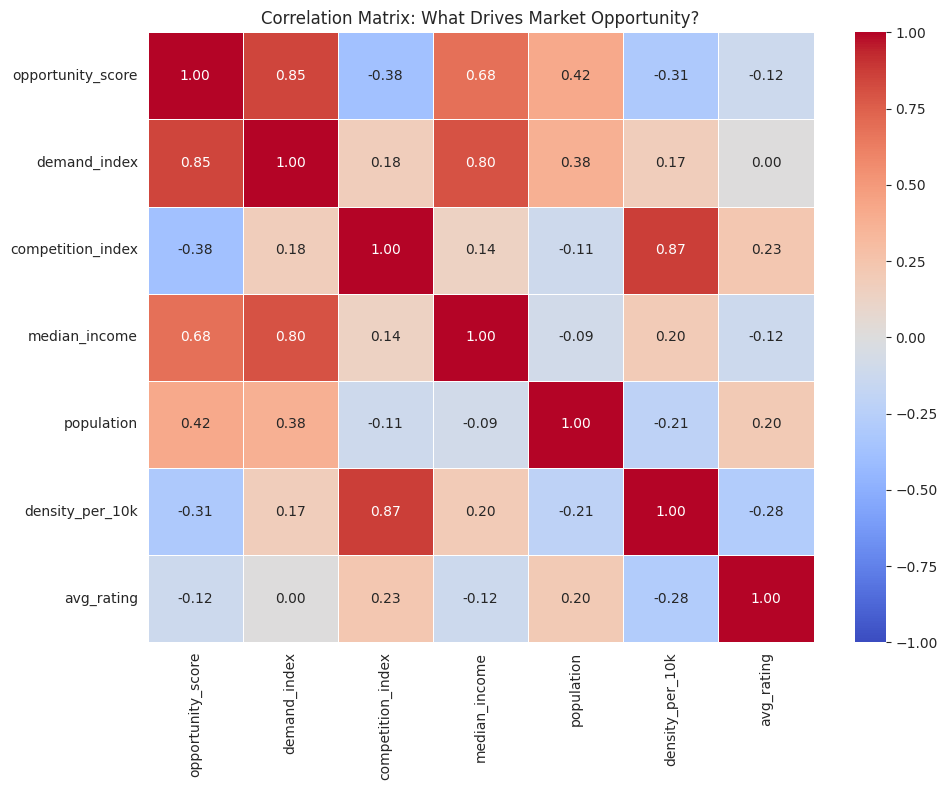

In [ ]:
plt.figure(figsize=(10, 8))
corr_cols = [
    "opportunity_score", "demand_index", "competition_index",
    "median_income", "population", "density_per_10k", "avg_rating"
]
# Calculate correlation only on numeric columns
corr_matrix = df_ranked[corr_cols].corr()

sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    vmin=-1, vmax=1
)
plt.title("Correlation Matrix: What Drives Market Opportunity?")
plt.tight_layout()
plt.show()

Based on the **Opportunity Index**, we have identified the top 15 cities for expansion. These markets exhibit a unique combination of high disposable income and an active coffee culture, yet lack the oversaturation.

**Interpretation:**
Based on our calculations the most promising plausible place for a market entry is *San Francisco, California*

/tmp/ipython-input-3220942132.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="opportunity_score", y="city_state", data=df_top, palette="viridis")


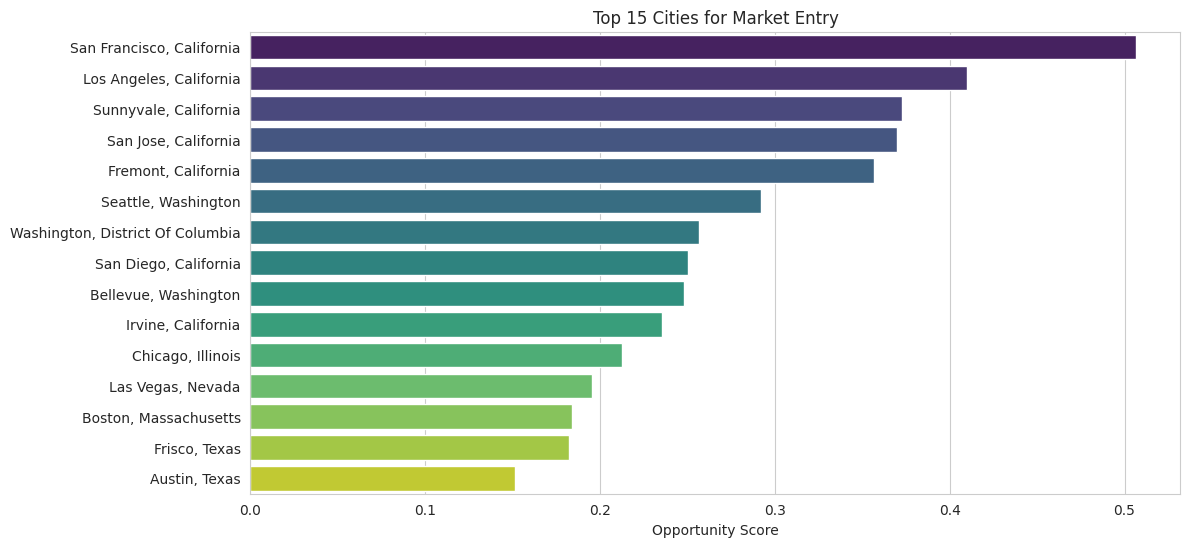

In [ ]:
top_n = 15
df_top = df_ranked.head(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x="opportunity_score", y="city_state", data=df_top, palette="viridis")
plt.title(f"Top {top_n} Cities for Market Entry")
plt.xlabel("Opportunity Score")
plt.ylabel("")
plt.show()

### The Strategy Matrix


**Interpretation:**

This quadrant analysis separates cities based on their market structure
* **Top Left:** Cities like *"San Francisco, California"* appear here. They have **High Demand** (Wealthy, Active) but **Low Competition**. These are "Blue Ocean" opportunities where a new shop can thrive without fighting for market share.
* **Top Right:** Cities with high demand but intense competition. Success here requires a massive marketing budget to steal customers from incumbents.
* **Bottom Half:** Cities with low income or low engagement like "*Pasadena, Texas*". Regardless of competition levels, the customer base simply isn't strong enough to support a premium pricing strategy.

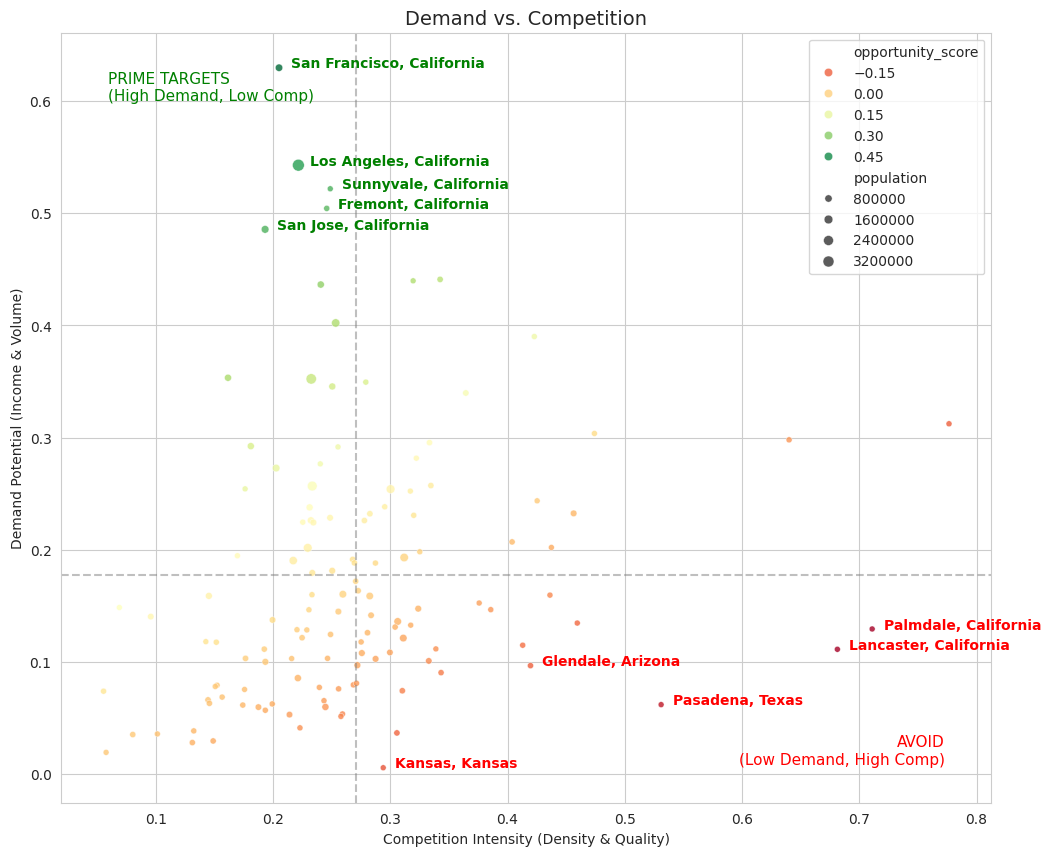

In [ ]:
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=df_ranked,
    x="competition_index",
    y="demand_index",
    size="population",
    hue="opportunity_score",
    palette="RdYlGn",
    alpha=0.8
)

# Top 5 labels
for i in range(5):
    row = df_ranked.iloc[i]
    plt.text(
        row["competition_index"] + 0.01,
        row["demand_index"],
        row["city_state"],
        fontweight='bold',
        fontsize=10,
        color='green'
    )

# Bottom 5 labels
for i in range(1, 6):
    row = df_ranked.iloc[-i]
    plt.text(
        row["competition_index"] + 0.01,
        row["demand_index"],
        row["city_state"],
        fontweight='bold',
        fontsize=10,
        color='red'
    )

plt.title("Demand vs. Competition", fontsize=14)
plt.xlabel("Competition Intensity (Density & Quality)")
plt.ylabel("Demand Potential (Income & Volume)")

plt.axhline(y=df_ranked["demand_index"].mean(), color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=df_ranked["competition_index"].mean(), color='gray', linestyle='--', alpha=0.5)

plt.text(0.05, 0.95, "PRIME TARGETS\n(High Demand, Low Comp)", transform=plt.gca().transAxes, fontsize=11, color='green', verticalalignment='top')
plt.text(0.95, 0.05, "AVOID\n(Low Demand, High Comp)", transform=plt.gca().transAxes, fontsize=11, color='red', horizontalalignment='right')

plt.show()

### Demand vs. Competition for Top 5 Cities

**Interpretation:**

This chart compares demand strength and competition intensity across the top five cities identified by the opportunity analysis. Reveals if a top city is a winner because of high demand or low competition.

- All cities exhibit strong demand signals, indicating sizable and economically attractive coffee markets. However, competitive pressure varies significantly between cities.
- *San Francisco* and *Los Angeles* show the highest demand but also face moderate competition, suggesting that market entry is viable with clear differentiation strategies.
- *San Jose* stands out with strong demand and comparatively lower competition, indicating a favorable balance between opportunity and risk.
- *Sunnyvale* and *Fremont*, while attractive in terms of demand, exhibit higher competitive intensity relative to their size, implying more saturated local markets.
- Overall, the analysis highlights that the most attractive entry opportunities arise where strong consumer demand is paired with manageable competition rather than demand alone.

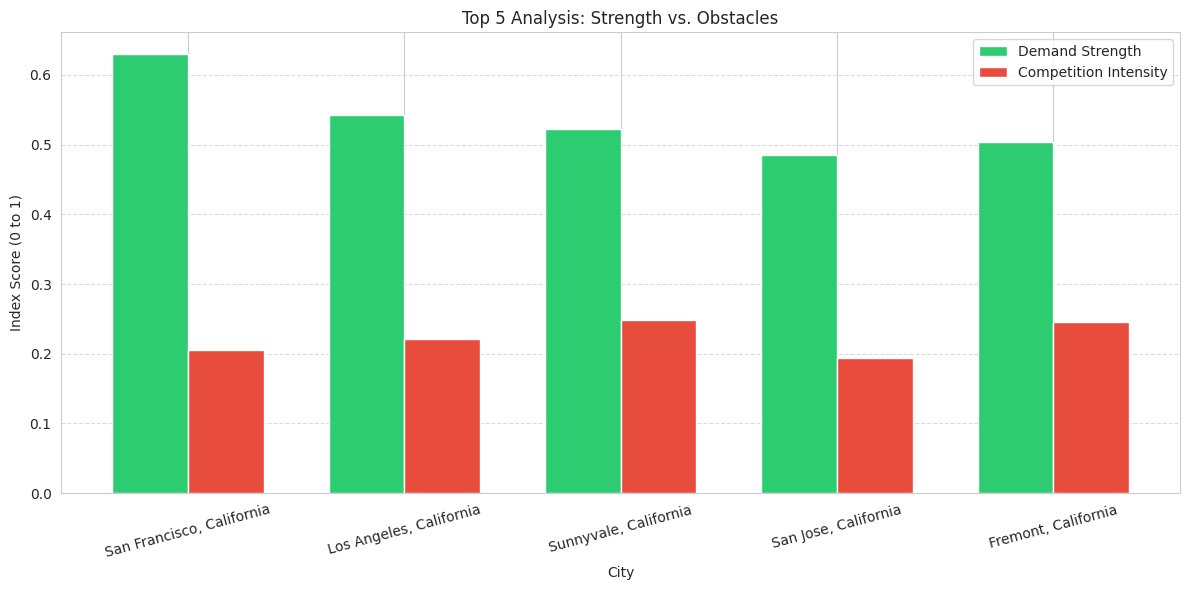

In [ ]:
top_5 = df_ranked.head(5).copy()

plt.figure(figsize=(12, 6))
x = np.arange(len(top_5))
width = 0.35

plt.bar(x - width/2, top_5["demand_index"], width, label="Demand Strength", color="#2ecc71")
plt.bar(x + width/2, top_5["competition_index"], width, label="Competition Intensity", color="#e74c3c")

plt.xlabel('City')
plt.ylabel('Index Score (0 to 1)')
plt.title('Top 5 Analysis: Strength vs. Obstacles')
plt.xticks(x, top_5["city_state"], rotation=15)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Distribution of Oppurtunity

This distribution illustrates how market opportunity scores are spread across the analyzed cities.

- Most cities cluster around slightly negative to modestly positive scores, indicating that average market conditions are competitive and do not inherently favor new entry.
- The dashed line represents the mean opportunity score, highlighting that only a subset of cities perform meaningfully above average.
- The right-skewed tail of the distribution shows that a small number of cities offer significantly stronger entry potential, driven by favorable combinations of demand strength and manageable competition. This reinforces the importance of selective, data-driven city targeting rather than broad market expansion.

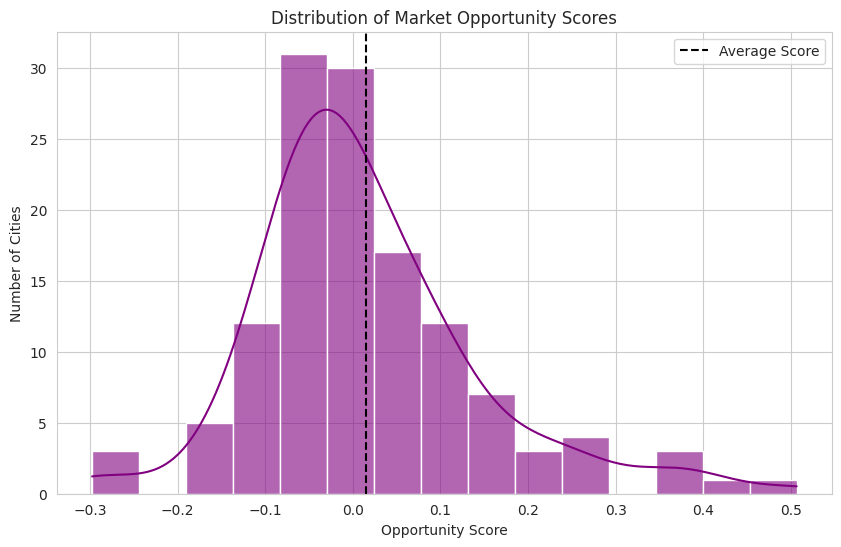

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_ranked["opportunity_score"], bins=15, kde=True, color="purple", alpha=0.6)
plt.axvline(df_ranked["opportunity_score"].mean(), color='black', linestyle='--', label="Average Score")

plt.title("Distribution of Market Opportunity Scores")
plt.xlabel("Opportunity Score")
plt.ylabel("Number of Cities")
plt.legend()
plt.show()

## Unsupervised Market Segmentation with Machine Learning
**Objective:** Identify structurally similar city markets to support strategic decision-making.

Since we lack historical "success/failure" labels for new coffee shops, we cannot use supervised prediction. Instead, we use **Unsupervised Learning (K-Means Clustering)** to discover latent market archetypes.

**Methodology:**
1.  **Features:** We select normalized indicators of Demand, Competition, and Affordability. *Note: We exclude the 'Opportunity Score' itself to avoid circular logic.*
2.  **Preprocessing:** Data is standardized (Z-Score) so that variables with large ranges (like Income) don't dominate variables with small ranges (like Ratings).
3.  **Optimal K:** We use the "Elbow Method" and "Silhouette Score" to determine the mathematically optimal number of clusters.
4.  **Interpretation:** We assign human-readable names to each cluster (e.g., "High-End Battlegrounds") based on their centroids.

### Preprocessing

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Feature Selection
model_features = [
    "median_income",
    "population",
    "density_per_10k",
    "avg_review_count",
    "avg_rating"
]

df_model = df_master[model_features].dropna()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model)

### Finding Optimal 'K'

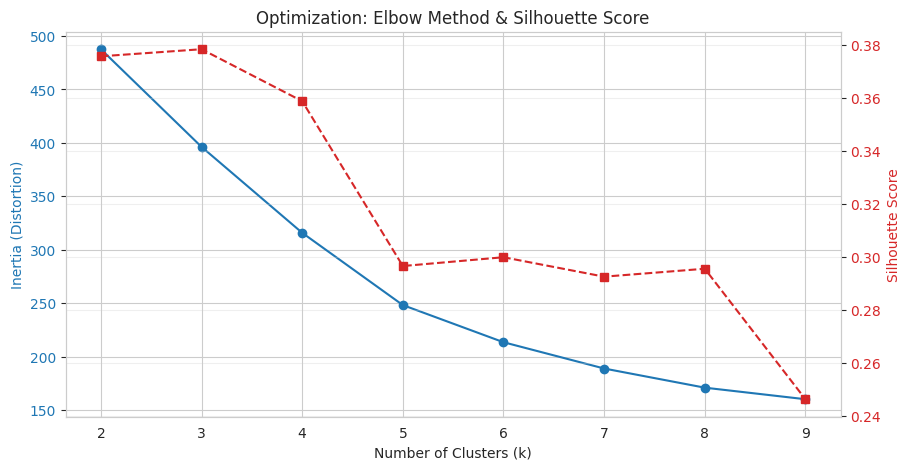

Mathematical Recommendation: k=3 clusters


In [ ]:
inertia = []
silhouette_vals = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_vals.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Metrics
fig, ax1 = plt.subplots(figsize=(10, 5))

# Inertia (Elbow)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Distortion)', color='tab:blue')
ax1.plot(k_range, inertia, marker='o', color='tab:blue', label='Inertia')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Silhouette Score
ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:red')
ax2.plot(k_range, silhouette_vals, marker='s', linestyle='--', color='tab:red', label='Silhouette')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Optimization: Elbow Method & Silhouette Score")
plt.grid(True, alpha=0.3)
plt.show()

# Automated selection of best K based on Silhouette
best_k = k_range[np.argmax(silhouette_vals)]
print(f"Mathematical Recommendation: k={best_k} clusters")

### Fit Model

Although the Silhouette Score peaks at **k=3**, we selected **k=4** for strategic reasons.

**The "Business Logic" Override:**
* **At k=3:** The model successfully separates "Low Opportunity" and "Average" cities, but it merges **"Wealthy Suburbs"** and **"Massive Metros"** (e.g., NYC, LA) into one group because both have high population and high income.
* **At k=4:** The model is forced to split that top tier. It separates the **"Mega Metros"** (which have extreme population density and require high-volume/low-margin strategies) from the **"Prime Targets"** (which are wealthy but less saturated).

**Conclusion:** We sacrifice a small amount of mathematical separation (lower Silhouette score) to gain significantly higher **strategic resolution**, allowing us to distinguish "Good Targets" from "Saturated Giants."

In [ ]:
# Run K-Means
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_master["cluster_id"] = kmeans_final.fit_predict(X_scaled)

### Interpret Clusters

In [ ]:
# Analyze Centroids
centroids = df_master.groupby("cluster_id")[model_features].mean()
centroids["city_count"] = df_master["cluster_id"].value_counts()
print("Cluster Archetypes")
display(centroids.round(2))

cluster_names = {
    0: "Prime Targets (Affluent/High-Engage)",
    1: "Standard Growth Markets",
    2: "Mega Metros (High Volume)",
    3: "Hyper-Saturated (Avoid)"
}

df_master["cluster_name"] = df_master["cluster_id"].map(cluster_names)

print("\nAssigned Market Segments")
display(df_master[["place_name", "cluster_name", "opportunity_score"]].head(10))

Cluster Archetypes


,median_income,population,density_per_10k,avg_review_count,avg_rating,city_count
cluster_id,,,,,,
0,108820.19,342835.63,392.54,543.03,4.30,27
1,72395.51,327551.14,156.70,184.32,4.34,90
2,70027.62,2029020.38,61.16,380.36,4.40,8
3,86796.50,189680.50,2168.79,400.03,4.09,4



Assigned Market Segments


,place_name,cluster_name,opportunity_score
0,"Huntsville city, Alabama",Standard Growth Markets,-0.025261
1,"Chandler city, Arizona",Standard Growth Markets,-0.035303
2,"Glendale city, Arizona",Standard Growth Markets,-0.155018
3,"Mesa city, Arizona",Standard Growth Markets,-0.046790
4,"Peoria city, Arizona",Standard Growth Markets,-0.102112
5,"Phoenix city, Arizona",Mega Metros (High Volume),0.073947
6,"Tempe city, Arizona",Standard Growth Markets,-0.141006
7,"Little Rock city, Arkansas",Standard Growth Markets,-0.092495
8,"Anaheim city, California",Prime Targets (Affluent/High-Engage),0.121127
9,"Bakersfield city, California",Standard Growth Markets,0.083007


### Model Interpretation & Findings
The K-Means model identified **4 distinct market archetypes**, which we have labeled based on their centroid characteristics:

| Cluster Label | Description | Strategic Implication |
| :--- | :--- | :--- |
| **Prime Targets** | High Income (~$108k), Strong Engagement, Moderate Competition. | **Primary Entry Point.** These markets offer the ideal balance of wealth and coffee culture without the extreme saturation of major metros. |
| **Standard Growth** | Moderate Income (~$72k), Average Density. | **Secondary Targets.** Viable for long-term expansion, but likely lower revenue per unit than Prime targets. |
| **Mega Metros** | Extreme Population (2M+). | **High Volume / High Cost.** Markets like Phoenix or Los Angeles. Requires different unit economics (high volume, lower margin) due to intense competition. |
| **Hyper-Saturated** | Extreme Competition Density (>2,000 per 10k). | **Avoid.** These outliers are overcrowded. The cost to acquire customers in such a noisy market is likely prohibitive. |

**Relationship to Opportunity Index:**
The clustering model complements our ranking system. While the "Opportunity Score" tells us *where* to go, these clusters tell us *what kind of strategy* is required to succeed there.

### Cluster Visualization

**Interpretation:**

The scatter plot visualizes the 4 machine learning clusters on our primary decision axes:
* **Green Points (Prime Targets):** Notice how this group clusters in the **Top-Left** (High Demand, Low Competition). This confirms that our "Blue Ocean" strategy aligns with a distinct structural market type.
* **Red Points (Hyper-Saturated):** These outliers are pushed far to the right, visually confirming their extreme density.
* **Orange/Blue Points:** The distinct separation between "Standard" (Blue) and "Mega Metros" (Orange) highlights that while both have moderate opportunity scores, they require fundamentally different operational scales.

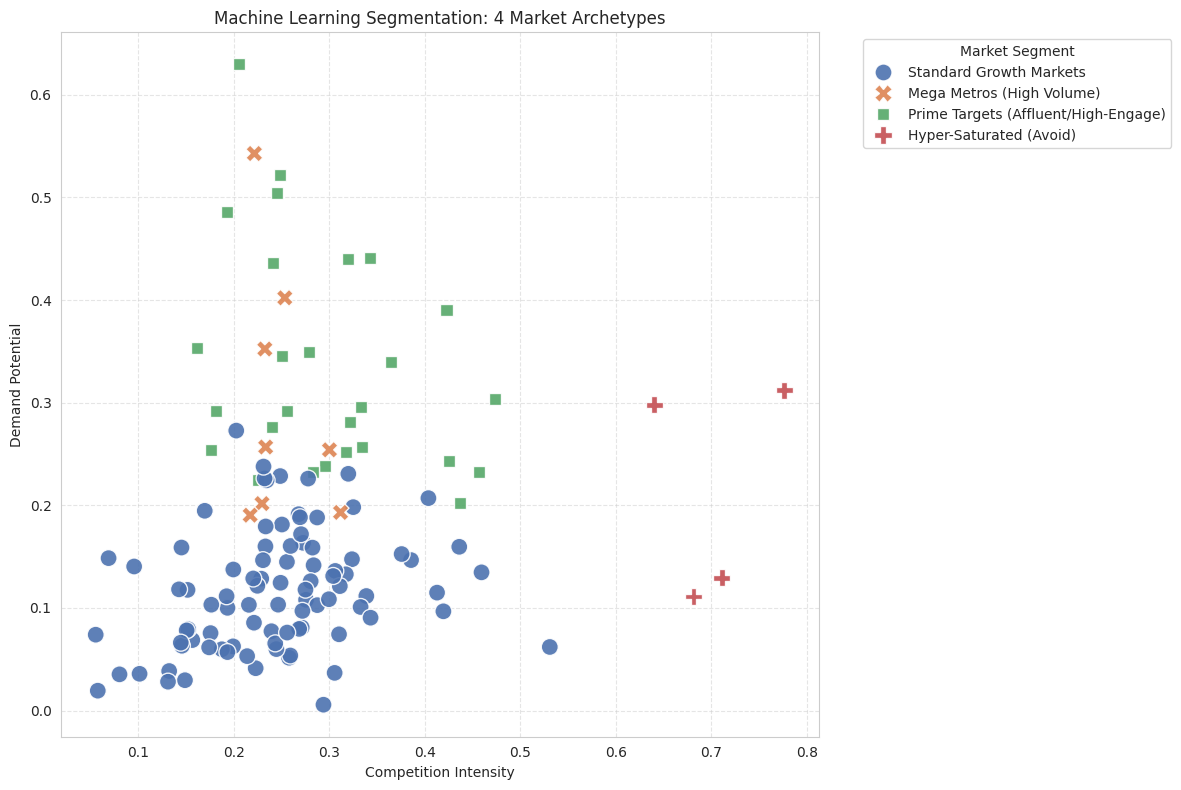

In [ ]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=df_master,
    x="competition_index",
    y="demand_index",
    hue="cluster_name",
    style="cluster_name",
    s=150,
    alpha=0.9,
    palette="deep"
)

plt.title("Machine Learning Segmentation: 4 Market Archetypes")
plt.xlabel("Competition Intensity")
plt.ylabel("Demand Potential")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Market Segment")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## References

1. **U.S. Census Bureau.**  
   *American Community Survey (ACS) 5-Year Estimates.*  
   Used for city-level demographic and socioeconomic indicators, including population size, median household income, and median age.  
   https://www.census.gov/programs-surveys/acs

2. **U.S. Census Bureau.**  
   *County Business Patterns (CBP).*  
   Used to measure market competition through establishment counts in NAICS category 72251 (Restaurants and Similar Eating Places) at the county level.  
   https://www.census.gov/programs-surveys/cbp

3. **U.S. Department of Transportation.**  
   *National Address Database / City–County Crosswalk.*  
   Used to harmonize city-level demographic data with county-level NAICS competition data and resolve geographic identifier mismatches.  
   https://www.transportation.gov/gis/national-address-database

4. **Yelp Inc.**  
   *Yelp Fusion API Documentation.*  
   Used to collect sampled café-level data including ratings, review counts, and price levels as proxies for consumer engagement and market positioning.  
   https://docs.developer.yelp.com/docs/fusion-intro

5. **North American Industry Classification System (NAICS).**  
   *NAICS 2017 / 2022 Manual.*  
   Used to identify relevant industry groupings for food services and coffee shop proxies (NAICS 72251).  
   https://www.census.gov/naics

6. **Pedregosa, F., et al. (2011).**  
   *Scikit-learn: Machine Learning in Python.*  
   Journal of Machine Learning Research, 12, 2825–2830.  
   Used for clustering algorithms, preprocessing, and evaluation metrics.  
   https://jmlr.org/papers/v12/pedregosa11a.html

7. **Hastie, T., Tibshirani, R., & Friedman, J. (2009).**  
   *The Elements of Statistical Learning: Data Mining, Inference, and Prediction.*  
   Springer.  
   Referenced conceptually for clustering methodology and unsupervised learning principles.

8. **Aggarwal, C. C. (2015).**  
   *Data Mining: The Textbook.*  
   Springer.  
   Referenced for clustering interpretation and market segmentation concepts.

---

### Notes on Data Limitations
Yelp data represents a sampled subset of businesses due to API rate limits and should not be interpreted as a full census of establishments. NAICS-based competition measures are used as a proxy for coffee shop density due to the absence of consistent 6-digit NAICS data at the county level.

All analyses and conclusions are derived from publicly available data sources and standard analytical methods.